# MUSA650 Final Project: Classifying Crop Types in Rwanda

**Kristin Chang (krchang@design.upenn.edu) & Jenna Epstein (jennaeps@design.upenn.edu)** | Spring 2022

## Accessing and Downloading our Data from Radiant MLHub
Please see this additional notebook that provides detailed instructures on how to download imagery from the Radiant MLHub using the API: https://github.com/jennaepstein/MUSA650_Final_ChangEpstein/blob/main/Accessing_MLHub_data.ipynb 

## Exploratory Data Analysis

In [1]:
# initial imports
from radiant_mlhub import Dataset, Collection, client, get_session
import tarfile
from pathlib import Path
import os
import shutil
from io import BytesIO
from glob import glob
from tqdm.notebook import tqdm
import tifffile as tiff
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL as pil
import json
import seaborn as sns
import keras
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [3]:
# Output path where the data is located and version of the path as a string
output_path = Path("./data/").resolve()
output_path_str = str(Path(output_path))

In [4]:
# Access to the data on local system
data_root=f"{output_path}/Images" 

In [5]:
# Print classes from the Images folder
selectedClasses = (os.listdir(data_root))
print (selectedClasses)

['banana', 'forest', 'legumes', 'maize', 'other', 'structure']


In [7]:
# Load Local Data JSON for Quick Analysis
## Note: This data downloaded and compiled from MLHub in separate Jupyter notebook called _Accesing_MLHub_data.ipynb_

# Df containing the keys
key_df = pd.read_json("key_df.json")

# View first five rows
key_df.head()

,index,source_file,label
0,4,C:\Users\jenna\Documents\MCP\Spring_2022\MUSA6...,structure
1,5,C:\Users\jenna\Documents\MCP\Spring_2022\MUSA6...,structure
2,8,C:\Users\jenna\Documents\MCP\Spring_2022\MUSA6...,structure
3,9,C:\Users\jenna\Documents\MCP\Spring_2022\MUSA6...,structure
4,10,C:\Users\jenna\Documents\MCP\Spring_2022\MUSA6...,structure


In [8]:
# Main dataset
dataset_df = pd.read_json("dataset_df.json")

# View first five rows
dataset_df.head()

,source_file,label
0,C:\Users\jenna\Documents\MCP\Spring_2022\MUSA6...,banana
1,C:\Users\jenna\Documents\MCP\Spring_2022\MUSA6...,maize
2,C:\Users\jenna\Documents\MCP\Spring_2022\MUSA6...,legumes
3,C:\Users\jenna\Documents\MCP\Spring_2022\MUSA6...,legumes
4,C:\Users\jenna\Documents\MCP\Spring_2022\MUSA6...,structure


In [9]:
# How many images are in the dataset
print("Total images in the dataset: ", len(dataset_df))

Total images in the dataset:  2606


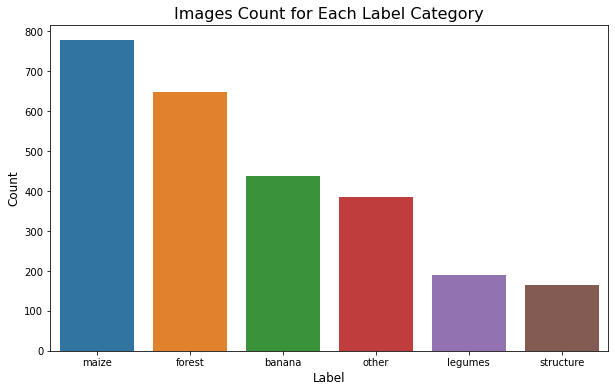

In [10]:
# Check image counts per category, just for reference
ac_count = dataset_df['label'].value_counts()
plt.figure(figsize=(10,6))
sns.barplot(x=ac_count.index, y=ac_count.values)
plt.title("Images Count for Each Label Category", fontsize=16)
plt.xlabel("Label", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show();

In [11]:
DATA_DIR = str(data_root) # data directory

### Creating data matrices

In [46]:
# Reading images from local images folder -- replace and comment out the duplicate
#dataPath = "C:/Users/kchan/Desktop/Spring2022/RemoteSensing/Final/FinalRepo/MUSA650_Final_ChangEpstein/data/Images"
dataPath = "C:/Users/jenna/Documents/MCP/Spring_2022/MUSA650_RemoteSensing/Final/MUSA650_Final_ChangEpstein/data/Images"

#array of unique labels
labelList = os.listdir(dataPath)

#read images
numClass = len(labelList)

lenClass = np.zeros(numClass)
for i in np.arange(0, numClass):
    lenClass[i] = len(os.listdir(dataPath + '/' + labelList[i]))
#returns the number of images in each class
lenClass 

array([438., 649., 190., 778., 385., 166.])

In [47]:
# Returns the total number of images
numImg = int(lenClass.sum())
numImg

2606

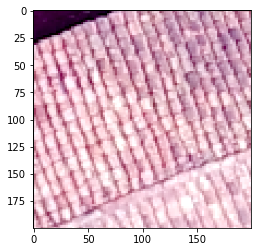

In [48]:
# Plotting one random image
import PIL

imgSel = dataPath + '/' + labelList[i] + '/' + os.listdir(dataPath + '/' + labelList[i])[25] #this can be any number between 0-165
img = PIL.Image.open(imgSel, 'r')
plt.imshow(np.asarray(img));

In [38]:
np.asarray(img).shape # 200x200 and 3 color channels

(200, 200, 3)

In [39]:
# Returns total number of pixels per each image
numPixels = np.prod(np.asarray(img).shape)
numPixels

120000

In [40]:
# Extract color channels from each image and flatten to a feature matrix X
X = np.zeros([numImg, numPixels])

# Create the numeric labels y for each image
y = np.zeros(numImg)

In [41]:
# creating a dictionary to make it easier to match up text labels with numeric
class_dict = dict(zip(labelList, range(len(labelList))))
class_dict  

{'banana': 0,
 'forest': 1,
 'legumes': 2,
 'maize': 3,
 'other': 4,
 'structure': 5}

In [ ]:
imgInd = 0
for i in np.arange(0, numClass):
  className = labelList[i]
  for imgName in os.listdir(dataPath + '/' + className):
    img = PIL.Image.open(dataPath + '/' + className + '/' + imgName, 'r')
    imgVec = np.asarray(img).flatten()
    X[imgInd,:] = imgVec
    y[imgInd] = i
    imgInd = imgInd + 1
    #print('Read img class ' + className + ' no ' + str(imgInd)) # comment out this line when exporting so it does not print

In [43]:
# Shape of X before splitting
X.shape

(2606, 120000)

In [44]:
# Shape of y before splitting
y.shape

(2606,)

### Plot sample images

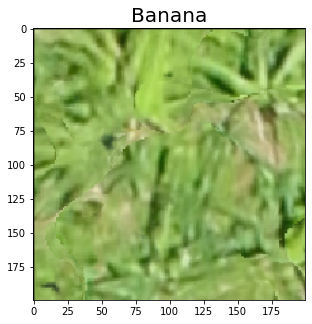

In [149]:
# Banana
plt.figure(figsize=(5,5))
imgSel = dataPath + '/' + labelList[0] + '/' + os.listdir(dataPath + '/' + labelList[0])[6]
img = PIL.Image.open(imgSel, 'r')
plt.imshow(np.asarray(img))
plt.title('Banana', fontsize=20);

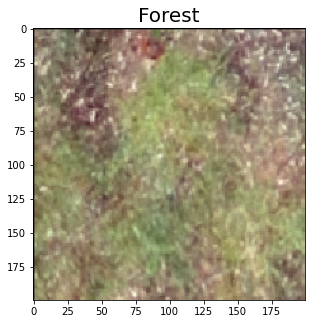

In [141]:
# Forest
plt.figure(figsize=(5,5))
imgSel = dataPath + '/' + labelList[1] + '/' + os.listdir(dataPath + '/' + labelList[1])[0]
img = PIL.Image.open(imgSel, 'r')
plt.imshow(np.asarray(img))
plt.title('Forest', fontsize=20);

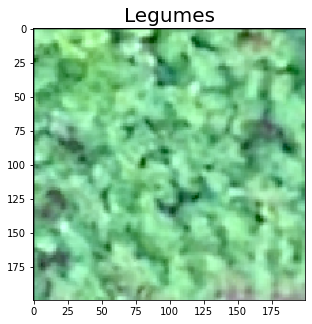

In [142]:
# Legumes
plt.figure(figsize=(5,5))
imgSel = dataPath + '/' + labelList[2] + '/' + os.listdir(dataPath + '/' + labelList[2])[44]
img = PIL.Image.open(imgSel, 'r')
plt.imshow(np.asarray(img))
plt.title('Legumes', fontsize=20);

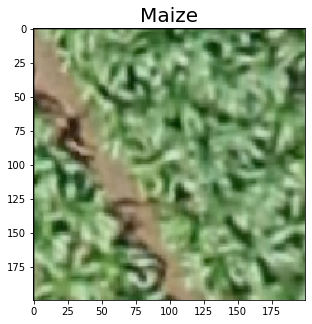

In [143]:
# Maize
plt.figure(figsize=(5,5))
imgSel = dataPath + '/' + labelList[3] + '/' + os.listdir(dataPath + '/' + labelList[3])[2]
img = PIL.Image.open(imgSel, 'r')
plt.imshow(np.asarray(img))
plt.title('Maize', fontsize=20);

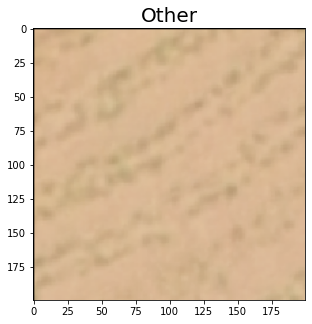

In [144]:
# Other
plt.figure(figsize=(5,5))
imgSel = dataPath + '/' + labelList[4] + '/' + os.listdir(dataPath + '/' + labelList[4])[3]
img = PIL.Image.open(imgSel, 'r')
plt.imshow(np.asarray(img))
plt.title('Other', fontsize=20);

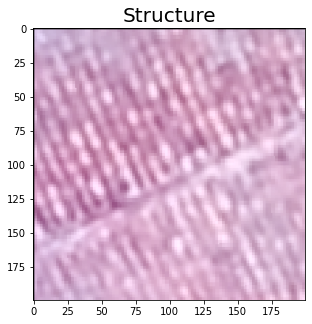

In [145]:
# Structure
plt.figure(figsize=(5,5))
imgSel = dataPath + '/' + labelList[5] + '/' + os.listdir(dataPath + '/' + labelList[5])[10]
img = PIL.Image.open(imgSel, 'r')
plt.imshow(np.asarray(img))
plt.title('Structure', fontsize=20);

## Supervised ML Approaches

### KNN Model

In [150]:
# Splitting the data, using stratify to ensure even distribution of each classes in each set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42, stratify=y)


In [151]:
X_train.shape

(2084, 120000)

In [152]:
X_test.shape

(522, 120000)

In [153]:
# Defining KNN classifier
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=5) # Start with 5 neighbors just to get baseline accuracy

In [154]:
# Scale and transform
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [155]:
# Train the model
knn_clf.fit(X_train, y_train)

KNeighborsClassifier()

In [32]:
# Apply the model
knn_preds = knn_clf.predict(X_test)

In [33]:
# Evaluate model
from sklearn.metrics import accuracy_score, plot_confusion_matrix
accuracy_score(y_test, knn_preds)

0.3946360153256705

In [46]:
# Optimize parameters -- NOTE: this takes 10 min or so to run
# Source: https://machinelearningknowledge.ai/knn-classifier-in-sklearn-using-gridsearchcv-with-example/

from sklearn.model_selection import GridSearchCV

# Defining range of parameters
k_range = list(range(1,31))
param_grid_knn = dict(n_neighbors = k_range)

#defining grid
grid_knn = GridSearchCV(knn_clf, param_grid_knn, cv=10, scoring='accuracy', return_train_score=False, verbose=1)

#fitting model for grid search
grid_search_knn = grid_knn.fit(X_train, y_train)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


In [47]:
# Print best parameters
print(grid_search_knn.best_params_) # 10 folds for 30 candidates range(1,31) defines 27 neighbors as optimal

{'n_neighbors': 27}


In [156]:
# Now that we have best params, run KNN again

# Defining knn classifier
knn_clf_best = KNeighborsClassifier(n_neighbors=27) # Using 27 from gridSearchCV

In [157]:
# Train the model
knn_clf_best.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=27)

In [158]:
# Apply the model
knn_preds_best = knn_clf_best.predict(X_test)

In [159]:
# Evaluate model
from sklearn.metrics import accuracy_score
accuracy_score(y_test, knn_preds_best)

0.41954022988505746

In [160]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

print("KNN accuracy score: ",accuracy_score(y_test,knn_preds_best))
print("KNN classification report \n",classification_report(y_test,knn_preds_best))

knn_cm = confusion_matrix(y_test,knn_preds_best,  labels = knn_clf_best.classes_)

KNN accuracy score:  0.41954022988505746
KNN classification report 
               precision    recall  f1-score   support

         0.0       0.91      0.11      0.20        88
         1.0       0.39      0.89      0.55       130
         2.0       0.18      0.05      0.08        38
         3.0       0.65      0.18      0.28       156
         4.0       0.26      0.42      0.32        77
         5.0       0.76      0.94      0.84        33

    accuracy                           0.42       522
   macro avg       0.53      0.43      0.38       522
weighted avg       0.55      0.42      0.36       522



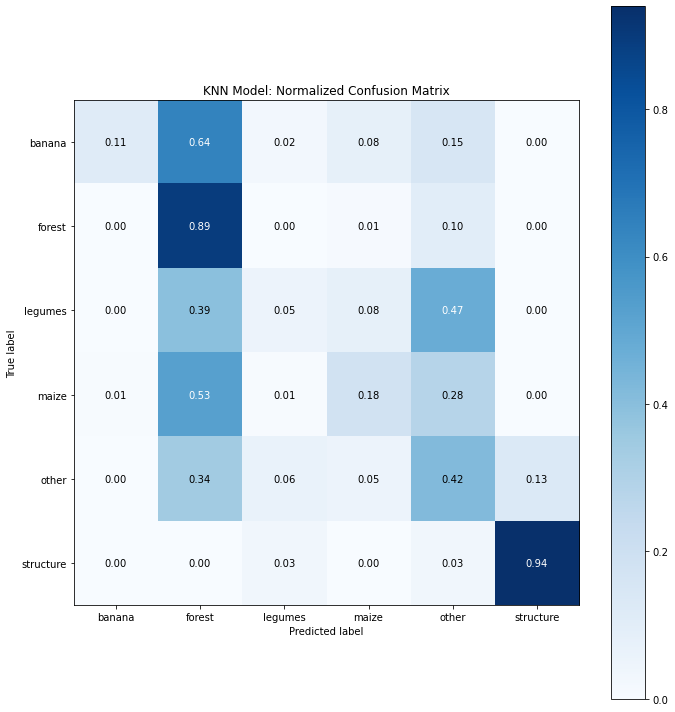

In [162]:
# Plot the confusion matrix
%matplotlib inline
cm = knn_cm.astype('float') / knn_cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Show all ticks
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # and label them with the respective list entries
       xticklabels=labelList, yticklabels=labelList,
       title='KNN Model: Normalized Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Loop over data dimensions and create text annotations
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()

### Random Forest

In [163]:
# Defining RF classifier
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(max_depth=10, n_estimators=100, max_features=1)

In [164]:
# Train the model
rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_features=1)

In [165]:
# Apply the model
rf_preds = rf_clf.predict(X_test)

In [166]:
# Evaluate model
accuracy_score(y_test, rf_preds)

0.6015325670498084

In [169]:
# Optimize parameters - should only take <5 min to run currently
# Source: https://stackoverflow.com/questions/30102973/how-to-get-best-estimator-on-gridsearchcv-random-forest-classifier-scikit
from sklearn.model_selection import GridSearchCV

# Defining range of parameters
param_grid_rf = {
    'max_depth': [5, 10, 15],
    'n_estimators': [200, 700, 900]
}

# Defining grid
grid_rf = GridSearchCV(rf_clf, param_grid_rf, cv=10, scoring='accuracy', return_train_score=False, verbose=1)

# Fitting model for grid search
grid_search_rf = grid_rf.fit(X_train, y_train)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


In [170]:
# Print best parameters
print(grid_search_rf.best_params_)

{'max_depth': 15, 'n_estimators': 200}


In [171]:
# Defining RF classifier with best params identified in CVGridSearch
rf_clf_best = RandomForestClassifier(max_depth=15, n_estimators=700, max_features=1)

In [172]:
# Train the model
rf_clf_best.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, max_features=1, n_estimators=700)

In [173]:
# Apply the model
rf_preds_best = rf_clf_best.predict(X_test)

In [174]:
# Evaluate model
accuracy_score(y_test, rf_preds_best)

0.6149425287356322

In [176]:
print("RF accuracy score: ",accuracy_score(y_test,rf_preds_best))
print("RF classification report \n",classification_report(y_test,rf_preds_best))

rf_cm = confusion_matrix(y_test,rf_preds_best, labels = rf_clf_best.classes_);

RF accuracy score:  0.6149425287356322
RF classification report 
               precision    recall  f1-score   support

         0.0       0.67      0.55      0.60        88
         1.0       0.61      0.68      0.64       130
         2.0       0.00      0.00      0.00        38
         3.0       0.55      0.83      0.66       156
         4.0       0.77      0.30      0.43        77
         5.0       0.86      0.97      0.91        33

    accuracy                           0.61       522
   macro avg       0.58      0.55      0.54       522
weighted avg       0.60      0.61      0.58       522



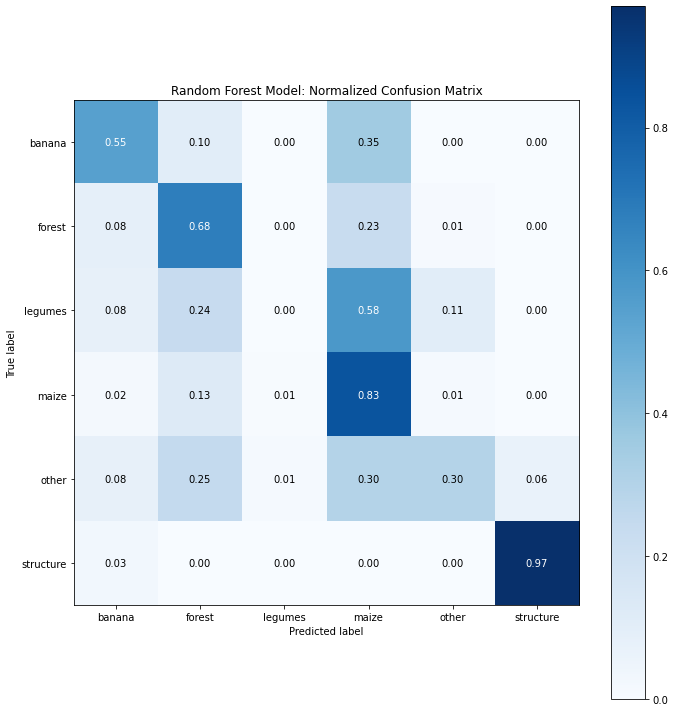

In [177]:
# Plot the confusion matrix
%matplotlib inline
cm = rf_cm.astype('float') / rf_cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Show all ticks
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # and label them with the respective list entries
       xticklabels=labelList, yticklabels=labelList,
       title='Random Forest Model: Normalized Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Loop over data dimensions and create text annotations
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()

## Deep Learning Attempts

### Simple CNN 1
_NOTE: This model was not included in our report, as we built off of it to develop Simple CNN 2._

In [178]:
# Reading in images and retaining RGB
import glob
import os

img_files = []

for file in glob.glob(dataPath + os.sep + "*" + os.sep + "*.png"):
    img_files.append(file)

In [179]:
# Load in the RGB images
from skimage import io

imgs_rgb = []

for imgName in img_files:
    temp = io.imread(imgName)
    imgs_rgb.append(temp)

In [180]:
# Convert to array
RGBimages = np.stack(imgs_rgb)

In [181]:
# Check shape
RGBimages.shape

(2606, 200, 200, 3)

In [182]:
# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(RGBimages,y,test_size=0.5, random_state=42, stratify=y)

In [183]:
# Scale and transform
from sklearn.preprocessing import MinMaxScaler
scalar = MinMaxScaler()
scalar.fit(X_train.reshape(X_train.shape[0], -1))
X_train = scalar.transform(X_train.reshape(X_train.shape[0], -1)).reshape(X_train.shape)
X_test = scalar.transform(X_test.reshape(X_test.shape[0], -1)).reshape(X_test.shape)

In [184]:
# Set global params
batch_size = 64
epochs = 12
input_shape =(200,200,3)

In [185]:
# Imports for deep learning
import tensorflow as tf 
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from tensorflow.keras.layers import BatchNormalization
from keras.utils.vis_utils import plot_model

In [186]:
cnn1 = Sequential()

cnn1.add(Conv2D(64, kernel_size=(3, 3),strides=(1,1),input_shape=input_shape))
cnn1.add(BatchNormalization())
cnn1.add(Activation('relu'))
cnn1.add(MaxPooling2D((2,2)))

cnn1.add(Dropout(0.5))

cnn1.add(Flatten())
cnn1.add(Dense(numClass, activation='softmax'))

cnn1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 198, 198, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 198, 198, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 99, 99, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 627264)            0         
_________________________________________________________________
dense (Dense)                (None, 6)                 3

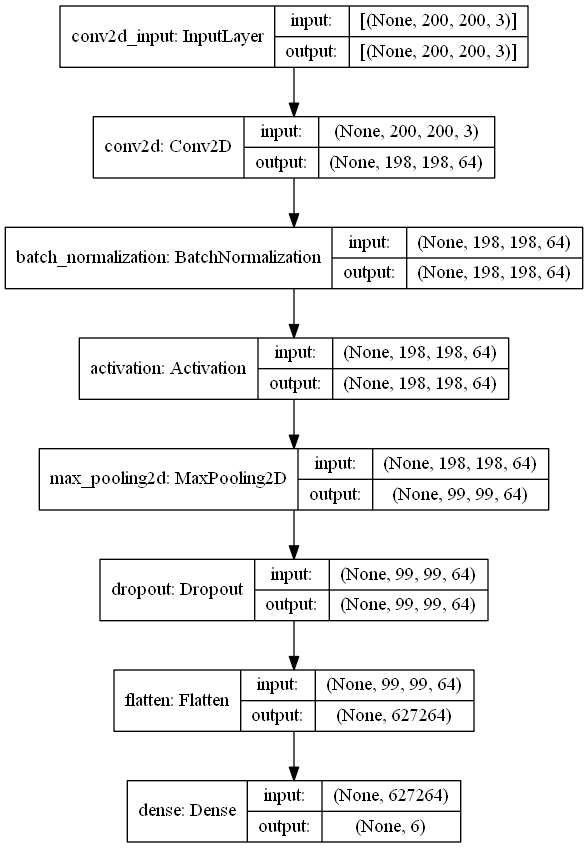

In [187]:
# Visualize cnn1
plot_model(cnn1, show_shapes=True, show_layer_names=True)

In [188]:
cnn1.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [190]:
history = cnn1.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test))

Epoch 1/12
21/21 [==============================] - 29s 1s/step - loss: 0.8775 - accuracy: 0.9079 - val_loss: 2.8539 - val_accuracy: 0.4735
Epoch 2/12
21/21 [==============================] - 31s 1s/step - loss: 1.1314 - accuracy: 0.9102 - val_loss: 3.3117 - val_accuracy: 0.5265
Epoch 3/12
21/21 [==============================] - 30s 1s/step - loss: 1.2118 - accuracy: 0.9094 - val_loss: 3.4763 - val_accuracy: 0.4497
Epoch 4/12
21/21 [==============================] - 29s 1s/step - loss: 0.6971 - accuracy: 0.9355 - val_loss: 3.1461 - val_accuracy: 0.5042
Epoch 5/12
21/21 [==============================] - 28s 1s/step - loss: 0.4301 - accuracy: 0.9570 - val_loss: 3.5815 - val_accuracy: 0.5403
Epoch 6/12
21/21 [==============================] - 28s 1s/step - loss: 0.2971 - accuracy: 0.9685 - val_loss: 3.6051 - val_accuracy: 0.5487
Epoch 7/12
21/21 [==============================] - 28s 1s/step - loss: 0.2852 - accuracy: 0.9678 - val_loss: 4.4720 - val_accuracy: 0.5211
Epoch 8/12
21/21 [==

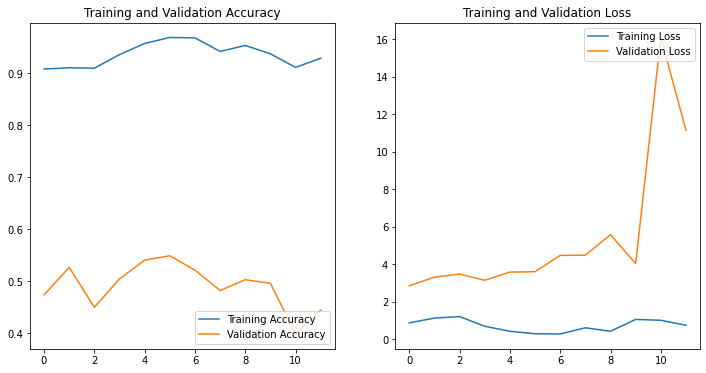

In [191]:
# Visualize metrics for cnn1

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [192]:
score = cnn1.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 11.143009185791016
Test accuracy: 0.4443591833114624


### Simple CNN 2

In [193]:
# Split original data for rescaling layer
X_train, X_test, y_train, y_test = train_test_split(RGBimages,y,test_size=0.5, random_state=42, stratify=y)

In [194]:
# Adding a rescaling layer to help with scaling the data. This is done in place of minmaxscalar to achieve similar effect.
from tensorflow.keras import layers
rescaling_layer = layers.experimental.preprocessing.Rescaling(
    scale=1. / 255,
    input_shape=input_shape)

In [195]:
cnn2 = Sequential()
cnn2.add(rescaling_layer)

cnn2.add(Conv2D(64, kernel_size=(3, 3),strides=(1,1),input_shape=input_shape))
cnn2.add(BatchNormalization())
cnn2.add(Activation('relu'))
cnn2.add(MaxPooling2D((2,2)))

cnn2.add(Dropout(0.5))

cnn2.add(Flatten())
cnn2.add(Dense(numClass, activation='softmax'))

cnn2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 198, 198, 64)      1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 198, 198, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 198, 198, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 99, 99, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 99, 99, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 627264)           

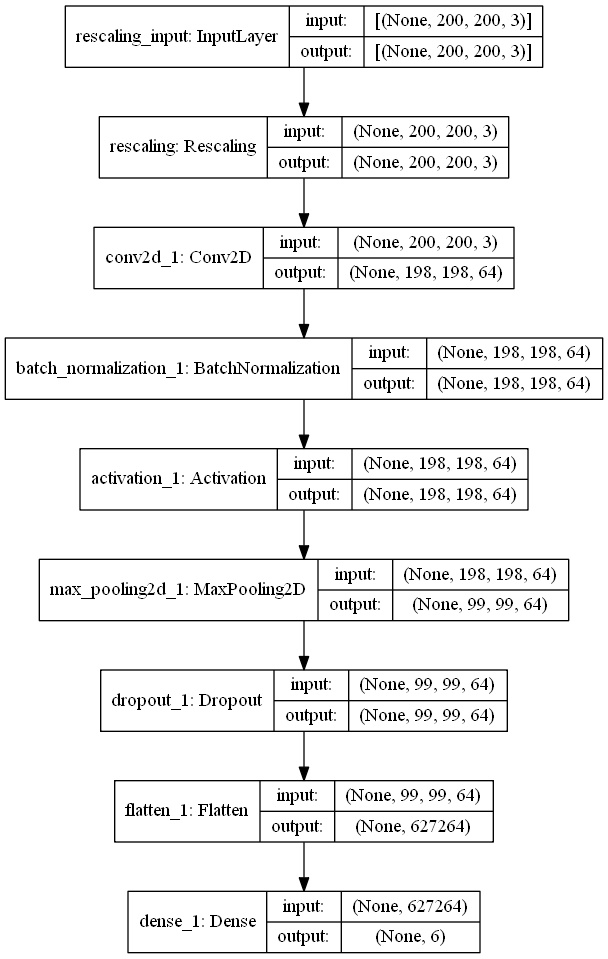

In [196]:
# Visualize cnn2
plot_model(cnn2, show_shapes=True, show_layer_names=True)

In [197]:
cnn2.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(), #attempted rmsprop and adadelta, but those were worse
              metrics=['accuracy'])

In [198]:
history = cnn2.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, y_test))

Epoch 1/12
21/21 [==============================] - 30s 1s/step - loss: 63.8913 - accuracy: 0.3569 - val_loss: 9.4499 - val_accuracy: 0.2218
Epoch 2/12
21/21 [==============================] - 30s 1s/step - loss: 18.7832 - accuracy: 0.5411 - val_loss: 9.7874 - val_accuracy: 0.1627
Epoch 3/12
21/21 [==============================] - 32s 2s/step - loss: 11.0176 - accuracy: 0.6424 - val_loss: 4.4342 - val_accuracy: 0.1896
Epoch 4/12
21/21 [==============================] - 32s 2s/step - loss: 6.0416 - accuracy: 0.7068 - val_loss: 2.0666 - val_accuracy: 0.2840
Epoch 5/12
21/21 [==============================] - 30s 1s/step - loss: 3.9619 - accuracy: 0.7621 - val_loss: 2.2302 - val_accuracy: 0.3668
Epoch 6/12
21/21 [==============================] - 29s 1s/step - loss: 2.9295 - accuracy: 0.7982 - val_loss: 2.3928 - val_accuracy: 0.3584
Epoch 7/12
21/21 [==============================] - 31s 1s/step - loss: 3.7566 - accuracy: 0.7897 - val_loss: 1.9603 - val_accuracy: 0.4605
Epoch 8/12
21/21 

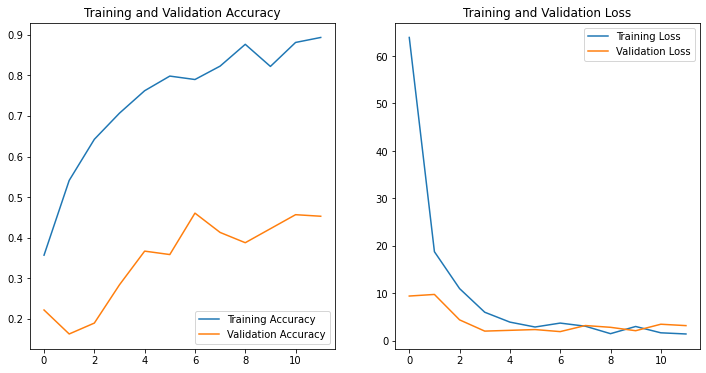

In [199]:
# Visualize metrics for cnn2

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [200]:
score = cnn2.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 3.2227249145507812
Test accuracy: 0.4528012275695801


## VGG16 

In [205]:
#  Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(RGBimages,y,test_size=0.5, random_state=42, stratify=y)

In [206]:
# Scale and transform
from sklearn.preprocessing import MinMaxScaler
scalar = MinMaxScaler()
scalar.fit(X_train.reshape(X_train.shape[0], -1))
X_train = scalar.transform(X_train.reshape(X_train.shape[0], -1)).reshape(X_train.shape)
X_test = scalar.transform(X_test.reshape(X_test.shape[0], -1)).reshape(X_test.shape)

In [207]:
from tensorflow.keras.applications.vgg16 import VGG16

vgg16_base_1 = VGG16(input_shape = input_shape, # Shape of our images
                    include_top = False, # Leave out the last fully connected layer
                    weights = 'imagenet')
vgg16_base_1.trainable = False

# Flatten the output layer to 1 dimension
x = layers.Flatten()(vgg16_base_1.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(256, activation='relu')(x) # 1024 ,512

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(numClass, activation='softmax')(x)

vgg16_model_1 = tf.keras.models.Model(vgg16_base_1.input, x)

#model1.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])
vgg16_model_1.compile(optimizer = 'adam',loss = 'sparse_categorical_crossentropy',metrics=['accuracy'])

vgg16_model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0   

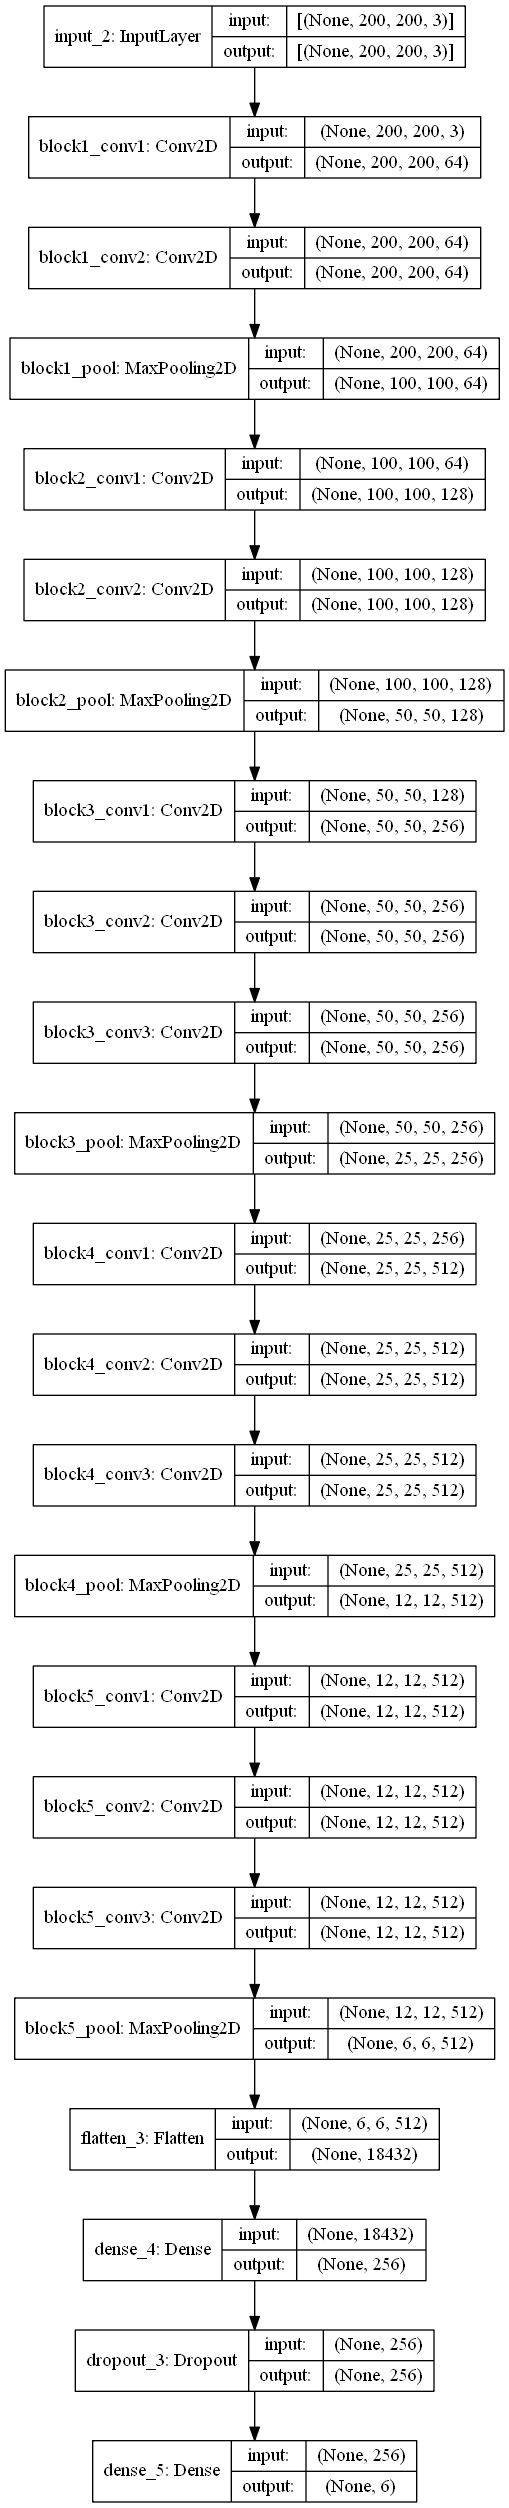

In [208]:
# Visualize vgg16_model_1
plot_model(vgg16_model_1, show_shapes=True, show_layer_names=True)

In [209]:
# Fit the model
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

history = vgg16_model_1.fit(X_train, y_train, 
                        epochs=12, 
                        validation_split=0.2, 
                        batch_size=64, 
                        callbacks=[es])


Epoch 1/12
17/17 [==============================] - 116s 7s/step - loss: 2.4548 - accuracy: 0.4117 - val_loss: 1.1723 - val_accuracy: 0.5670
Epoch 2/12
17/17 [==============================] - 110s 7s/step - loss: 1.0825 - accuracy: 0.6142 - val_loss: 1.0193 - val_accuracy: 0.6284
Epoch 3/12
17/17 [==============================] - 113s 7s/step - loss: 0.9563 - accuracy: 0.6516 - val_loss: 0.9975 - val_accuracy: 0.6015
Epoch 4/12
17/17 [==============================] - 120s 7s/step - loss: 0.8674 - accuracy: 0.6708 - val_loss: 0.9675 - val_accuracy: 0.6743
Epoch 5/12
17/17 [==============================] - 115s 7s/step - loss: 0.8406 - accuracy: 0.6862 - val_loss: 0.9572 - val_accuracy: 0.6552
Epoch 6/12
17/17 [==============================] - 115s 7s/step - loss: 0.7494 - accuracy: 0.7284 - val_loss: 0.9378 - val_accuracy: 0.6590
Epoch 7/12
17/17 [==============================] - 116s 7s/step - loss: 0.7041 - accuracy: 0.7370 - val_loss: 0.8877 - val_accuracy: 0.6897
Epoch 8/12
17

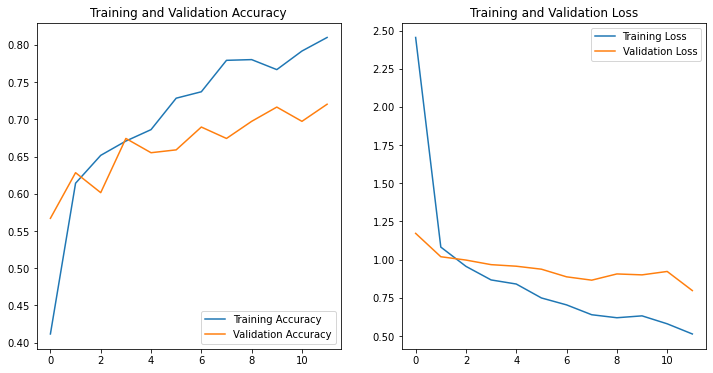

In [210]:
# Visualize training and accuracy metrics for vgg model

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [211]:
score = vgg16_model_1.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.7031996846199036
Test accuracy: 0.7751343250274658


In [212]:
# Get the results with label error for each class
vgg_results = vgg16_model_1.predict(X_test)

In [213]:
# y_preds using argmax (index of highest probability indicates predicted class)
y_preds = np.argmax(vgg_results, axis=1)

In [214]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

         0.0       0.91      0.87      0.89       219
         1.0       0.72      0.93      0.81       325
         2.0       0.56      0.34      0.42        95
         3.0       0.84      0.87      0.85       389
         4.0       0.66      0.39      0.49       192
         5.0       0.74      0.84      0.79        83

    accuracy                           0.78      1303
   macro avg       0.74      0.71      0.71      1303
weighted avg       0.77      0.78      0.76      1303



In [215]:
from sklearn.metrics import confusion_matrix
vgg_cm = confusion_matrix(y_test, y_preds)

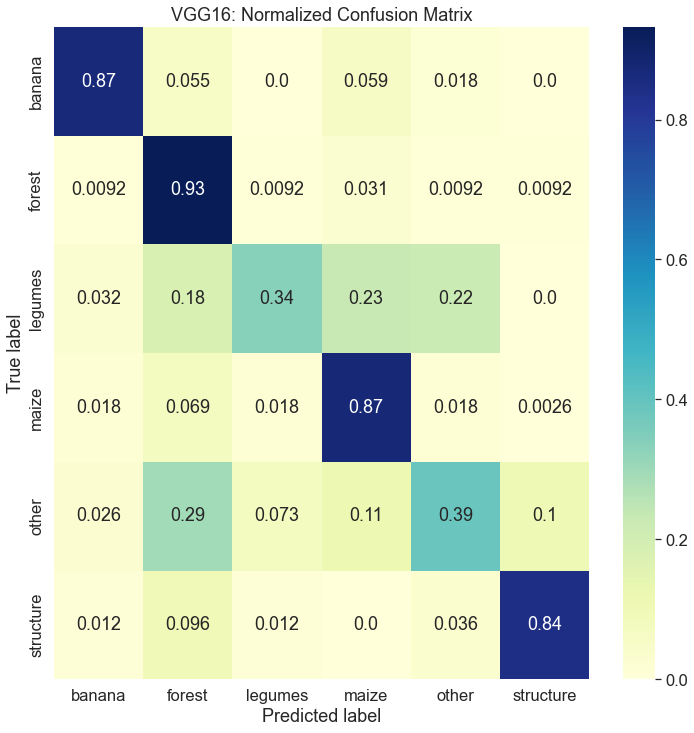

In [217]:
# Plot a nicer confusion matrix with seaborn
import seaborn as sns
vgg_cm = confusion_matrix(y_test, y_preds)

# Normalize
vgg_cm = vgg_cm.astype('float') / vgg_cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize = (12,12))
sns.set(font_scale=1.5) #increasing font for legibility

# Labels, title, and ticks
ax=sns.heatmap(vgg_cm, xticklabels = selectedClasses, yticklabels = selectedClasses, annot=True, fmt='.2',cmap='YlGnBu')
ax.set(xlabel='Predicted label', ylabel='True label', title='VGG16: Normalized Confusion Matrix');

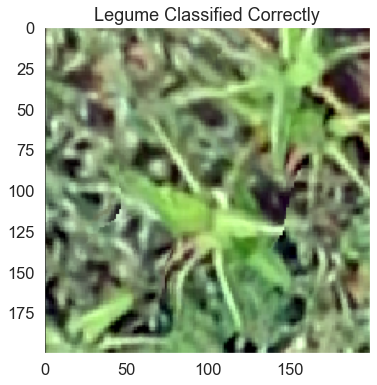

In [218]:
# Example of a "Legume" image classified successfully
plt.rcParams["axes.grid"] = False
plt.figure(figsize=(6, 6))
legume_success_1 = np.where((y_test == 2) & (y_preds == 2))[0][1]
legume_success_1_img = io.imread(img_files[legume_success_1])
plt.imshow(legume_success_1_img)
plt.title('Legume Classified Correctly');

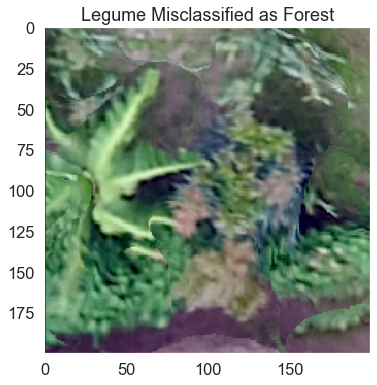

In [219]:
# Example of a "Legume" image classified unsuccessfully (as forest)
plt.rcParams["axes.grid"] = False
plt.figure(figsize=(6, 6))
legume_success_1 = np.where((y_test == 2) & (y_preds == 1))[0][1]
legume_success_1_img = io.imread(img_files[legume_success_1])
plt.imshow(legume_success_1_img)
plt.title('Legume Misclassified as Forest');

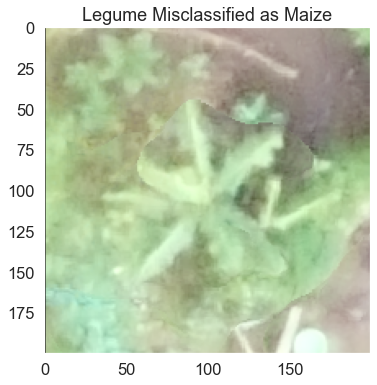

In [229]:
# Example of a "Legume" image classified unsuccessfully (as maize)
plt.rcParams["axes.grid"] = False
plt.figure(figsize=(6, 6))
legume_success_1 = np.where((y_test == 2) & (y_preds == 3))[0][1]
legume_success_1_img = io.imread(img_files[legume_success_1])
plt.imshow(legume_success_1_img)
plt.title('Legume Misclassified as Maize');

## MobileNetV2

### Data Augmentation before applying the model


In [230]:
#https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255, # rescale
    validation_split=.2, # validation split
    rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180) - 30%
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width) - 10%
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height) - 10%
    horizontal_flip=True,  # randomly flip images horizontally
    zoom_range=0.2,
)

In [231]:
TRAINING_DATA_DIR = str(data_root) # Data directory for training
train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR,
    target_size=(224, 224), # Image size - needs to be 224x224 for this model
    shuffle = True, # Randomize
    subset='training') # Set subset as training data

# Validation data is a subset of training data, so we use train_datagen for the validation generator too
validation_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR, # Same directory as training data
    target_size=(224, 224),
    shuffle = True, # Randomize
    subset='validation') # Set subset as validation data

Found 2087 images belonging to 6 classes.
Found 519 images belonging to 6 classes.


In [232]:
datagen_kwargs = dict(rescale=1./255,validation_split=.2) # split for the test data on the training data.
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
test_generator = test_datagen.flow_from_directory(
    TRAINING_DATA_DIR,
    subset="training",
    shuffle=False,
    target_size=(224,224)
)

Found 2087 images belonging to 6 classes.


In [233]:
from keras.callbacks import ModelCheckpoint

# Save the best weights over the same file with the model name, just in case
modelName= "mobilenet_model"
modelpath = f"{modelName}_bestweights.hdf5"
checkpoint = ModelCheckpoint(modelpath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [234]:
from keras.applications.mobilenet_v2 import MobileNetV2
mobilenet_model = MobileNetV2(weights='imagenet')

In [235]:
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.layers import Dense, Input, Dropout
from keras.models import Model

def build_model( ):
    input_tensor = Input(shape=(224, 224, 3))
    base_model = MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_tensor=input_tensor,
        input_shape=(224, 224, 3),
        pooling='avg')

    for layer in base_model.layers:
        layer.trainable = False  # trainable has to be false in order to freeze the layers
        
    op = Dense(256, activation='relu')(base_model.output)
    op = Dropout(.1)(op)

    output_tensor = Dense(6, activation='softmax')(op) # 6 is number of classes

    mobilenet_model = Model(inputs=input_tensor, outputs=output_tensor)


    return mobilenet_model

In [236]:
mobilenet_model = build_model()
mobilenet_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [453]:
# Visualize MobileNetV2 model
#plot_model(mobilenet_model, show_shapes=True, show_layer_names=True) # This is a very large output - uncomment only if desired

In [237]:
# Modal Summary
mobilenet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [238]:
train_generator.reset()
validation_generator.reset()

# Fit the model
history = mobilenet_model.fit(
    train_generator, 
    validation_data = validation_generator,
    epochs = 12, # using 12
    verbose=1)

Epoch 1/12
66/66 [==============================] - 56s 796ms/step - loss: 1.0420 - accuracy: 0.6358 - val_loss: 0.9314 - val_accuracy: 0.6474
Epoch 2/12
66/66 [==============================] - 53s 798ms/step - loss: 0.7424 - accuracy: 0.7326 - val_loss: 0.8259 - val_accuracy: 0.7091
Epoch 3/12
66/66 [==============================] - 51s 774ms/step - loss: 0.6695 - accuracy: 0.7628 - val_loss: 0.8656 - val_accuracy: 0.6840
Epoch 4/12
66/66 [==============================] - 50s 764ms/step - loss: 0.6477 - accuracy: 0.7690 - val_loss: 0.7833 - val_accuracy: 0.7187
Epoch 5/12
66/66 [==============================] - 54s 819ms/step - loss: 0.6061 - accuracy: 0.7944 - val_loss: 0.7579 - val_accuracy: 0.7476
Epoch 6/12
66/66 [==============================] - 53s 800ms/step - loss: 0.5848 - accuracy: 0.7801 - val_loss: 0.7662 - val_accuracy: 0.7303
Epoch 7/12
66/66 [==============================] - 52s 791ms/step - loss: 0.5689 - accuracy: 0.8055 - val_loss: 0.7226 - val_accuracy: 0.7553

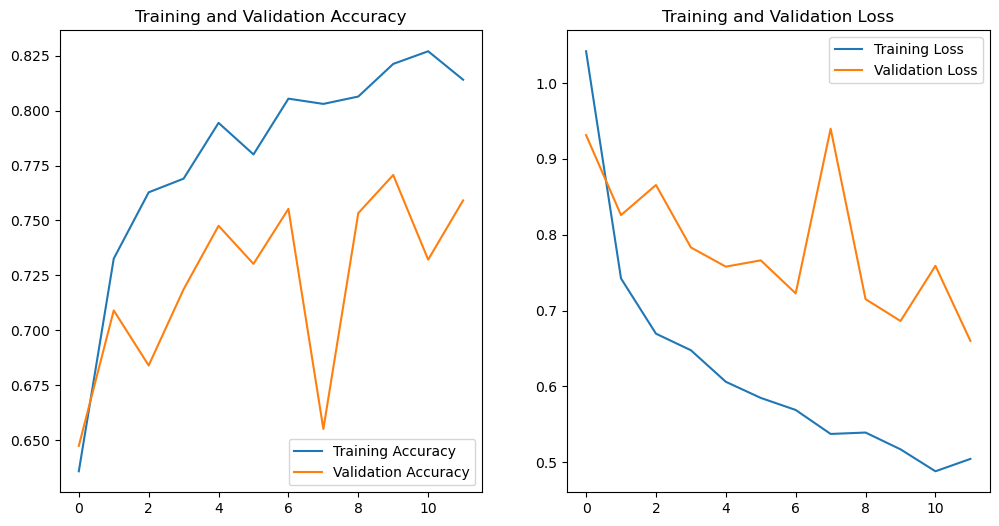

In [242]:
# Visualize metrics for the MobileNetV2 model
from matplotlib import rcParams, rcParamsDefault
rcParams.update(rcParamsDefault)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [240]:
# Loss and accuracy on validation
loss_val, accuracy_val = mobilenet_model.evaluate(validation_generator)
print("loss_val: ", loss_val)
print("accuracy_val: ", accuracy_val)

17/17 [==============================] - 10s 616ms/step - loss: 0.6697 - accuracy: 0.7688
loss_val:  0.6696935296058655
accuracy_val:  0.7687861323356628


In [241]:
# Set up model for test set images
test_generator.reset()

predictions = mobilenet_model.predict(test_generator,  verbose = 1)

66/66 [==============================] - 20s 287ms/step


In [243]:
len(predictions) # Predictions - store model predictions on the test set

2087

In [244]:
predicted_class_indices=np.argmax(predictions,axis=1)

# y_predictions contains predicted results in an array
y_predictions = np.argmax(mobilenet_model.predict(test_generator), axis=-1)

In [245]:
# y_actual is the actual class of the image to be predicted
y_actual=np.array(test_generator.classes)
y_actual = y_actual.astype(np.int64)

In [247]:
accuracy_score(y_actual, y_predictions) # Evaluating accuracy on the test set

0.7910876856732152

In [248]:
print(classification_report(y_actual, y_predictions, target_names=selectedClasses)) # Classification report


              precision    recall  f1-score   support

      banana       0.97      0.90      0.94       351
      forest       0.70      0.98      0.82       520
     legumes       0.58      0.45      0.51       152
       maize       0.92      0.78      0.84       623
       other       0.62      0.53      0.57       308
   structure       0.88      0.80      0.84       133

    accuracy                           0.79      2087
   macro avg       0.78      0.74      0.75      2087
weighted avg       0.80      0.79      0.79      2087



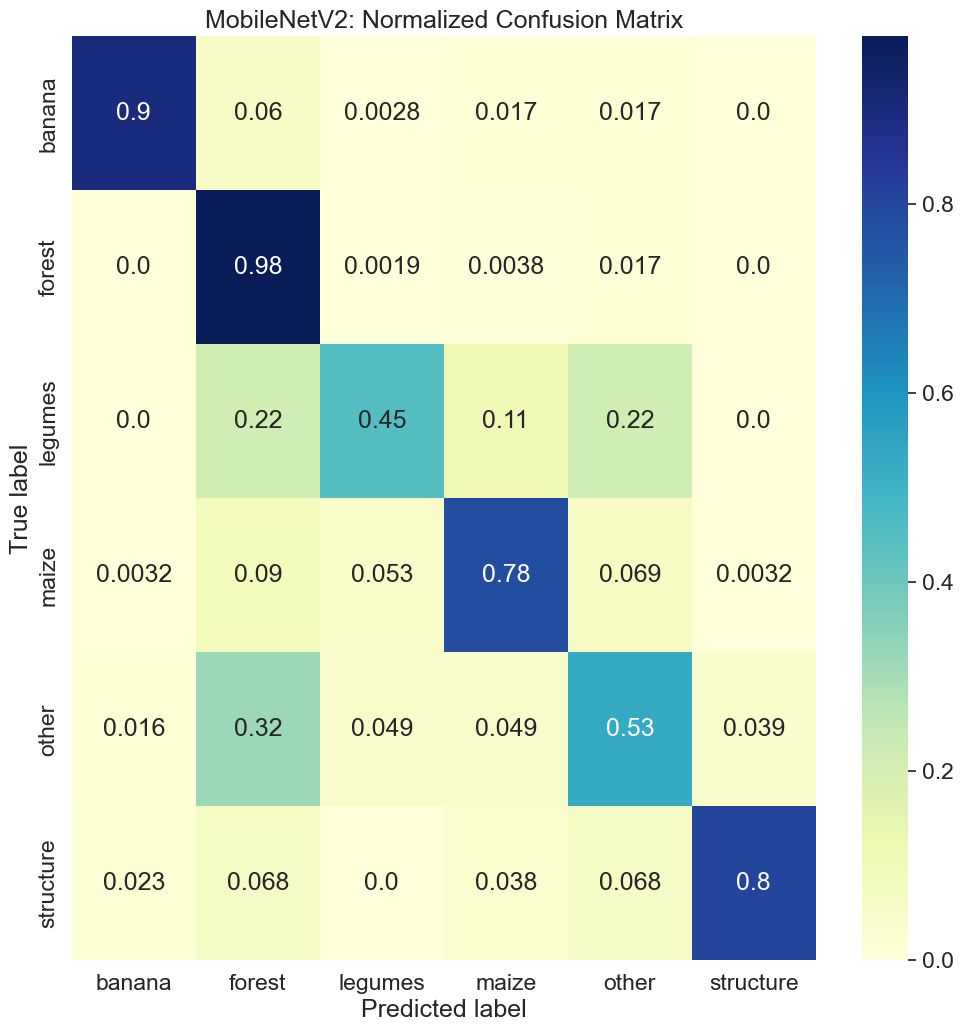

In [249]:
# Plot a nicer confusion matrix with seaborn
from sklearn.metrics import confusion_matrix
import seaborn as sns

mobilenet_cm = confusion_matrix(y_actual, y_predictions)

# Normalize
mobilenet_cm = mobilenet_cm.astype('float') / mobilenet_cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize = (12,12))
sns.set(font_scale=1.5) # increasing font for legibility

# Labels, title, and ticks
ax=sns.heatmap(mobilenet_cm, xticklabels = selectedClasses, yticklabels = selectedClasses, annot=True, fmt='.2',cmap='YlGnBu')
ax.set(xlabel='Predicted label', ylabel='True label', title='MobileNetV2: Normalized Confusion Matrix');

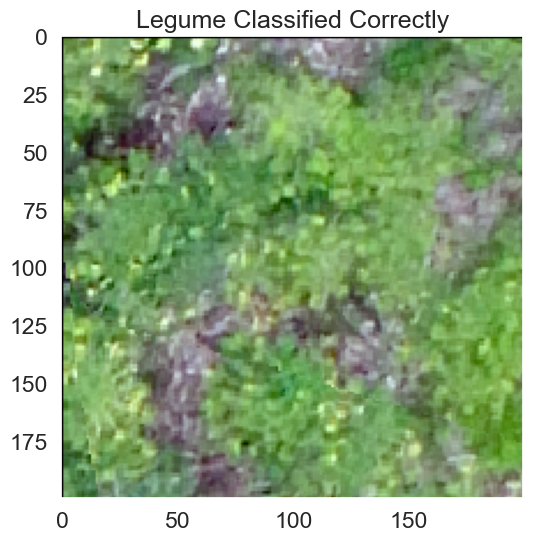

In [270]:
# Example of a "Legume" image classified successfully
plt.rcParams["axes.grid"] = False
plt.figure(figsize=(6, 6))
legume_success_2 = np.where((y_actual == 2) & (y_predictions == 2))[0][34]
legume_success_2_img = io.imread(img_files[legume_success_2])
plt.imshow(legume_success_2_img)
plt.title('Legume Classified Correctly');

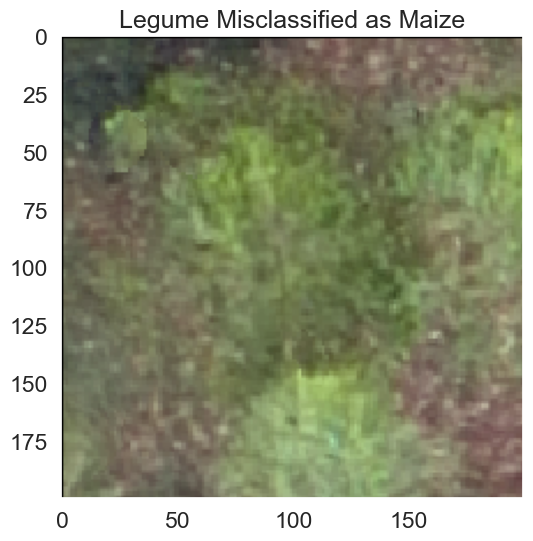

In [275]:
# Example of a "Legume" image classified poorly
plt.rcParams["axes.grid"] = False
plt.figure(figsize=(6, 6))
legume_success_2 = np.where((y_actual == 2) & (y_predictions == 3))[0][8]
legume_success_2_img = io.imread(img_files[legume_success_2])
plt.imshow(legume_success_2_img)
plt.title('Legume Misclassified as Maize');

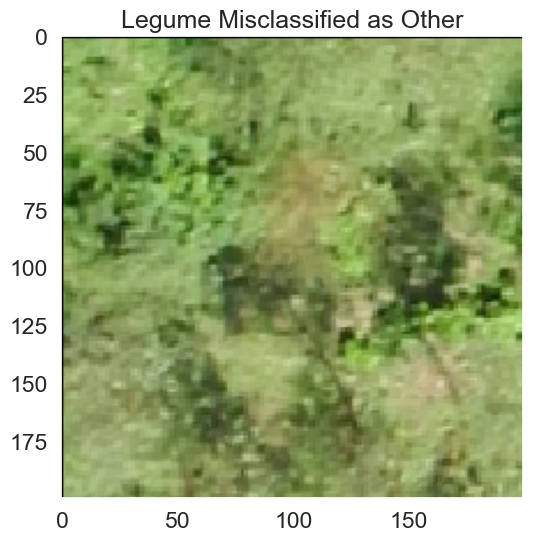

In [290]:
# Example of a "Legume" image classified poorly
plt.rcParams["axes.grid"] = False
plt.figure(figsize=(6, 6))
legume_success_2 = np.where((y_actual == 2) & (y_predictions == 4))[0][18]
legume_success_2_img = io.imread(img_files[legume_success_2])
plt.imshow(legume_success_2_img)
plt.title('Legume Misclassified as Other');